In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker
from matplotlib.offsetbox import AnchoredText
import itertools
import collections 
import matplotlib as mpl
import matplotlib.artist as artists
from scipy import stats
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib as mpl
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LogNorm

%matplotlib inline 
plt.style.use('figures')
from figure_dict import *


C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
#input file 
fin = "output/Function/Function-all-table.csv"
act = pd.read_csv(fin)
act = act.set_index('Protein')

fin = "output/CD-titration/Titration-ddG.csv"
dG = pd.read_csv(fin)
dG = dG.set_index('Protein')

fin = "output/Thermalmelt/Thermalmelt-Tm.csv"
Tm = pd.read_csv(fin)
Tm = Tm.set_index('Protein')

In [4]:
df = dG.join(Tm).join(act)
df["color_p"] = df.index.to_series().map(colordictFit)
df["label_p"] = df.index.to_series().str.replace('_','\n')
df.head()

,dG_NI,dG_NI_err,dG_IU,dG_IU_err,dG_total,dG_total_err,ddG_NI,ddG_NI_err,ddG_IU,ddG_IU_err,...,ddG_keff (kcal/mol),ddG_keff (kcal/mol)_err,interaction_Km (kcal/mol),interaction_kcat (kcal/mol),interaction_keff (kcal/mol),interaction_Km_err (kcal/mol),interaction_kcat_err (kcal/mol),interaction_keff_err (kcal/mol),color_p,label_p
Protein,,,,,,,,,,,,,,,,,,,,,
SsWT,7.012923,0.088782,4.177736,0.244579,11.190659,0.260194,0.000000,0.125556,0.000000,0.345887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0.898039215686, 0.847058823529, 0.81960784313...",SsWT
I45A,5.294199,0.062555,4.602300,0.122942,9.896499,0.137942,1.718724,0.108606,-0.424564,0.273740,...,0.04,0.04,NaN,NaN,NaN,NaN,NaN,NaN,"(0.898039215686, 0.847058823529, 0.81960784313...",I45A
I45K,5.266828,0.098302,7.251193,0.748855,12.518021,0.755280,1.746095,0.132460,-3.073457,0.787784,...,-0.06,0.04,NaN,NaN,NaN,NaN,NaN,NaN,"(0.8, 0.250980392157, 0.227450980392, 1.0)",I45K
S70A,8.543742,0.111201,6.133988,0.664460,14.677731,0.673701,-1.530819,0.142295,-1.956252,0.708043,...,-0.04,0.04,NaN,NaN,NaN,NaN,NaN,NaN,"(0.83137254902, 0.858823529412, 0.901960784314...",S70A
M73A,4.243023,0.184898,5.965681,0.171122,10.208703,0.251932,2.769900,0.205108,-1.787945,0.298499,...,0.63,0.07,NaN,NaN,NaN,NaN,NaN,NaN,"(0.482352941176, 0.623529411765, 0.97647058823...",M73A


In [5]:
#Output
dirOut = "output/Analysis/"
analysis = "ddG_activity_vs_stability"
fout = dirOut+analysis+'-scatter.pdf'

In [6]:
def autolabel(p, x, y, ax, slope, intercept):

    for prot, x_val, y_val in zip(p, x, y):
        ypred = intercept+slope*x_val
        if (prot in ["I45K", "I45K\nI107K"]):
            x_shift = -0.3
        elif (prot in ["I45A\nS70A"]):
            x_shift = 0.3
        else:
            x_shift = 0
        if (prot in ["I45A", "M73A", "I45A\nM73A", "I45K\nI107A"]):
            va = "top"
            if (prot in ["I45A", "M73A"]):
                y_shift = 0.04
            else: 
                y_shift = 0.06
        else:
            va="bottom"
            if (prot in ["S70A", "I107K", "I107A",   "I45K"]):
                y_shift = -0.04
            else: 
                y_shift = -0.06
        ax.text(x_val+x_shift, y_val+y_shift, prot, ha='center', va=va, size=14)        
    return

def scatter(df, ax, x_col, y_col):
    ax.axvline(x=0, color = "lightgrey", linestyle = ":", zorder=0)
    ax.axhline(y=0, color = "lightgrey", linestyle = ":", zorder=0)

    temp = df.sort_values(by = [x_col])
    x = temp[x_col]
    y = temp[y_col]
    col_p = temp["color_p"]
    lab_p = temp["label_p"]
    #get order of magnitude
    ordermag = pow(10, (math.ceil(math.log10((max(y))))))
    y_shift = ordermag/10 * 0.05
    
    ax.tick_params(axis='both') 
    #ax.scatter(x, y, c= col_p , marker="o", s=30, linewidth='0.5', edgecolor='black', label='_nolegend_')
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ax.scatter(x, y, c= col_p , marker="o", s=120, linewidth='0.5',  label='_nolegend_')
    
    minxaxis = min(x)-2
    maxxaxis = max(x)+2

    autolabel(lab_p, x, y, ax, slope, intercept)
    paddingx = 1
    paddingy = 0.1

    ax.set_xlim([min(x)-paddingx,max(x)+paddingx])
    ax.set_ylim([min(y)-paddingy,max(y)+paddingy])

    ax.legend(loc = 'best', fontsize=16)
    #ax.text(max(x)-1, max(y), u'$R= %.2f$' % r_value, ha='left', va='center', color = "black")
    return

def createGraph(xycombo, analysis, df):
    #always use 2 columns
    num_row = int(round(len(xycombo)/2+0.5))
    fig = plt.figure(figsize=(figsize["Height"],figsize["Double"])) 
    gs = gridspec.GridSpec(nrows=num_row, ncols=1)
    #fig.suptitle(analysis)

    for i, xy in enumerate (xycombo):
        x_col = str(xy[0])
        y_col = str(xy[1])
        if x_col in labeldict.keys():
            x_label = labeldict[x_col] 
        else: 
            x_label = ""
        if  y_col in labeldict.keys():
            y_label = labeldict[y_col]
        else:
            y_label = ""
        ax = plt.subplot(gs[i])
        fig_subtitle = y_label + " vs " + x_label
        #ax.set_title(fig_subtitle)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        scatter(df, ax, x_col, y_col)

    cmap = mpl.cm.get_cmap("coolwarm")
    norm = mpl.colors.Normalize(vmin= -0.2, vmax=0.2)
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    m.set_array([])
    cbar = plt.colorbar(m)
    cbar.set_label('s', rotation=90,labelpad=10)
    
    xoffset = 0.2
    yoffset = 0.05
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom-yoffset, top+yoffset) 
    
    left, right = ax.get_xlim() 
    ax.set_xlim(left-xoffset, right+1.5*xoffset)
    #ylim(left, right) 
    
    plt.text(left,top,"Stabilization of\nnon-productive\nconformation",horizontalalignment='left', verticalalignment='center')
    plt.text(left,bottom,"Stabilization of\nproductive\nconformation",horizontalalignment='left', verticalalignment='center')
    plt.text(right+yoffset*1.5,top,"Destabilization of\nproductive\nconformation",horizontalalignment='right', verticalalignment='center')
    plt.text(right+yoffset*1.5,bottom,"Destabilization of\nnon-productive\nconformation",horizontalalignment='right', verticalalignment='center')


    fig.tight_layout()
    fig.subplots_adjust(top = .95)
    
    return fig


## Figure 6 - b ##

C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


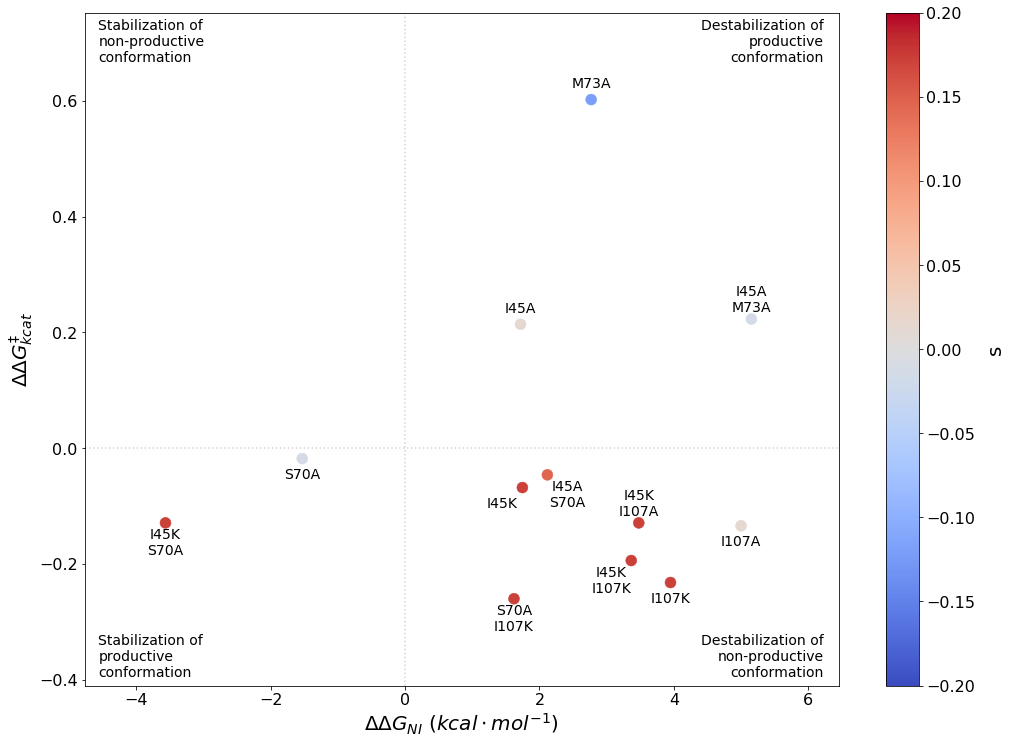

In [7]:
# remove SsWT
df2 = df.drop('SsWT', axis=0)

a = [["ddG_NI"],["ddG_kcat (kcal/mol)"]]
xycombo = list(itertools.product(*a))

#creates 2x2 panel of scatter plots 
fig = createGraph(xycombo, analysis, df2)
fig.show()